**Tema: Análisis de la actividad de un negocio minorista.**

**Autor: Francisco Moyano Escalera.**

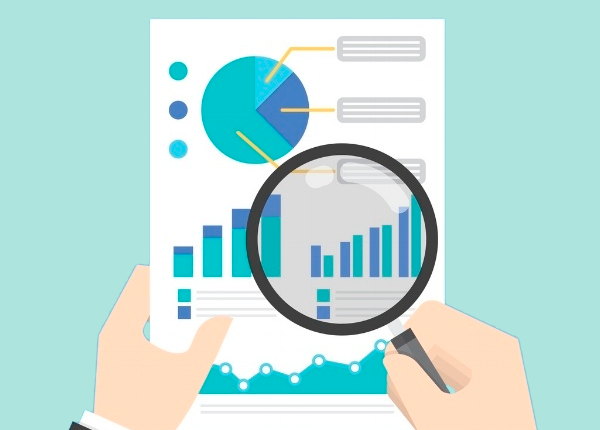

**1) Introducción**

Se cuenta con una base de datos de productos vendidos por un minorista de manera on-line a clientes de distintos países. 
El fin del presente proyecto es analizar la actividad del negocio a través del de un estudio pormenorizado de los ingresos mensuales y el cálculo de tres métricas fundamentales: la tasa de clientes nuevos, la tasa de retención de clientes y la tasa de abandono.


**2) Fuente de datos**

La base de datos cuenta con ocho columnas compuestas por:

- InvoiceNo: número de factura
- StockCode: código de stock
- Description: descripción del producto
- Quantity: cantidad comprada del producto
- InvoiceDate: fecha de la factura
- UnitPrice: precio unitario del producto
- CustomerID: identificación del cliente
- Country: país de procedencia del cliente



**3) Adquisición de datos**

In [ ]:
# Se realiza la conexión con Google Drive, en donde se encuentra almacenada la base de datos:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Se importan las librerías a utilizar:
# ============================================================================================================================================
# Configuración warnings:
import warnings
warnings.filterwarnings("ignore")
# ============================================================================================================================================
# Tratamiento, exploración y visualización de datos:
! pip install chart_studio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.offline as pyoff
import plotly.graph_objs as go
from scipy import stats                           
from scipy.stats import norm  
from scipy.stats.stats import pearsonr



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Se carga la base de datos en un dataframe:
data = pd.read_excel("/content/drive/MyDrive/Proyectos/Marketing/Online Retail.xlsx")


In [ ]:
# Se imprime el encabezado del conjunto de datos:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Se observa la dimensión del dataframe:
n_filas, n_columnas = data.shape
print("Tiene", n_filas, "filas y", n_columnas, "columnas")

Tiene 541909 filas y 8 columnas


In [ ]:
# Se observa en detalle los nombres de las columnas y los tipos de datos:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Inicialmente el dataframe cuenta con 8 columnas, de las cuales 4 son cualitativas, 3 cuantitativas, y 1 columna es de tipo date.

**4) Limpieza y transformación de datos (Data Wrangling)**


In [ ]:
# Se convierte en variable cualitativa la columna "CustomerID":
data["CustomerID"] = data["CustomerID"].astype("object")

In [ ]:
# Se convierte en variable datetime la columna "InvoiceDate":
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])


In [ ]:
# Se comprueba que la transformaciones se realizaron correctamente:
assert data["CustomerID"].dtype == "object"
assert data["InvoiceDate"].dtype == "datetime64[ns]"

In [ ]:
# Se modifican los nombres de las variables originales para facilitar el análisis:
data = data.rename(columns={"InvoiceNo": "N_Factura", 
                            "StockCode": "N_Stock",
                            "Description": "Descripcion",
                            "Quantity": "Cantidad",
                            "InvoiceDate": "F_Factura",
                            "UnitPrice": "Precio",
                            "CustomerID": "ID_Cliente",
                            "Country": "Pais",
                            })
# Se observa en detalle las columnas:
data.columns

Index(['N_Factura', 'N_Stock', 'Descripcion', 'Cantidad', 'F_Factura',
       'Precio', 'ID_Cliente', 'Pais'],
      dtype='object')

In [ ]:
# Se determina si el dataframe cuenta con datos duplicados:
duplicados = data.duplicated(keep=False) # Con keep=False se mantienen todos los duplicados
data[duplicados].sort_values(by="ID_Cliente") # Se ordenan las filas por ID_Cliente para visualizar bien los duplicados


,N_Factura,N_Stock,Descripcion,Cantidad,F_Factura,Precio,ID_Cliente,Pais
395388,571034,23239,SET OF 4 KNICK KNACK TINS POPPIES,6,2011-10-13 12:47:00,4.15,12359.0,Cyprus
395410,571034,23239,SET OF 4 KNICK KNACK TINS POPPIES,6,2011-10-13 12:47:00,4.15,12359.0,Cyprus
395442,571034,23494,VINTAGE DOILY DELUXE SEWING KIT,3,2011-10-13 12:47:00,5.95,12359.0,Cyprus
395443,571034,23494,VINTAGE DOILY DELUXE SEWING KIT,3,2011-10-13 12:47:00,5.95,12359.0,Cyprus
395455,571034,23245,SET OF 3 REGENCY CAKE TINS,4,2011-10-13 12:47:00,4.95,12359.0,Cyprus
...,...,...,...,...,...,...,...,...
424915,573290,23396,LE JARDIN BOTANIQUE CUSHION COVER,1,2011-10-28 14:51:00,3.75,NaN,Switzerland
483004,577489,23221,REINDEER HEART DECORATION SILVER,1,2011-11-20 12:07:00,0.83,NaN,United Kingdom
483010,577489,23221,REINDEER HEART DECORATION SILVER,1,2011-11-20 12:07:00,0.83,NaN,United Kingdom
514740,579744,23010,CIRCUS PARADE BABY GIFT SET,1,2011-11-30 14:38:00,16.95,NaN,United Kingdom


In [ ]:
# Se eliminan los registros duplicados: 
data.drop_duplicates(inplace= True)

In [ ]:
# Se examina si el dataframe tiene datos faltantes:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum() / data.isnull().count() * 100)
percent.sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ["Total Faltantes", "Porcentaje"])
missing_data

,Total Faltantes,Porcentaje
ID_Cliente,135037,25.163377
Descripcion,1454,0.270945
N_Factura,0,0.000000
N_Stock,0,0.000000
Cantidad,0,0.000000
F_Factura,0,0.000000
Precio,0,0.000000
Pais,0,0.000000


Existen dos columnas con valores nulos (NaN), sin embargo ninguna presenta un porcentaje alto de datos faltantes que obligue a eliminarla. A su vez, son dos columnas cualitativas, en el caso que fueran cuantitativas se podrían imputar dichos valores con la media o mediana.

In [ ]:
# Se crea la columna Mes:
data["Mes"] = data["F_Factura"].map(lambda date: 100*date.year + date.month)
# Se crea la columna Ingreso:
data["Ingreso"] = data["Precio"] * data["Cantidad"]

In [ ]:
# Se observa el dataframe con las nuevas columnas:
data.tail(2)

,N_Factura,N_Stock,Descripcion,Cantidad,F_Factura,Precio,ID_Cliente,Pais,Mes,Ingreso
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,201112,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,201112,14.85


**5) Análisis Exploratorio**

**- Variables Cuantitativas**

In [ ]:
# Se identifican las variables cuantitativas:
cuantitativas_1 = data.select_dtypes(include= "float64" ).columns.tolist()
cuantitativas_2 = data.select_dtypes(include= "int64" ).columns.tolist()
ColumnasCuantitativas = cuantitativas_1 + cuantitativas_2
ColumnasCuantitativas

['Precio', 'Ingreso', 'Cantidad', 'Mes']

In [ ]:
# Se define una función para identificar si hay variables cuasiconstantes:
def IsQuasiConstant(df, treshold=0.90):
  agrupado = df.value_counts(normalize = True)
  if agrupado.iloc[0] >= treshold:
   return True
  return False 

In [ ]:
# Se itera en cada una de las columnas cuantitativas para determinar cuales son cuasiconstantes en base al treshold fijado:
Columnas_Cuasi_Const_Cuant = [ ]
for col in ColumnasCuantitativas:
  if IsQuasiConstant(data[col]):
    Columnas_Cuasi_Const_Cuant.append(col)

Columnas_Cuasi_Const_Cuant

[]

Del análisis anterior se deduce que el dataframe cuenta con variables cuantitativas con amplia variedad de datos, ya que ninguna de éstas es cuasi-constante.

In [ ]:
# Se crea la tabla de distribución de frecuencias de la variable Precio:
Precio_absoluto = data["Precio"].value_counts().to_frame("Frecuencia Absoluta").reset_index().rename(columns={"index":"Precio"}) 
Precio_relativo = data["Precio"].value_counts(normalize=True).mul(100).to_frame("Frecuencia Relativa").reset_index().rename(columns={"index":"Precio"})                  
Precio_tabla = Precio_absoluto.merge(Precio_relativo, on="Precio")
Precio_tabla

,Precio,Frecuencia Absoluta,Frecuencia Relativa
0,1.25,49750,9.270630
1,1.65,37627,7.011578
2,0.85,28182,5.251556
3,2.95,27350,5.096517
4,0.42,24277,4.523881
...,...,...,...
1625,46.86,1,0.000186
1626,28.66,1,0.000186
1627,156.45,1,0.000186
1628,11.00,1,0.000186


Se observa que los precios con mayor frecuencia son los correspondientes a productos económicos.

In [ ]:
# Se crea la tabla de distribución de frecuencias de la variable Cantidad
Cantidad_absoluta = data["Cantidad"].value_counts().to_frame("Frecuencia Absoluta").reset_index().rename(columns={"index":"Cantidad"}) 
Cantidad_relativa = data["Cantidad"].value_counts(normalize=True).mul(100).to_frame("Frecuencia Relativa").reset_index().rename(columns={"index":"Cantidad"})                  
Cantidad_tabla = Cantidad_absoluta.merge(Cantidad_relativa, on="Cantidad")
Cantidad_tabla

,Cantidad,Frecuencia Absoluta,Frecuencia Relativa
0,1,144495,26.925822
1,2,81245,15.139544
2,12,60858,11.340542
3,6,40656,7.576015
4,4,38393,7.154317
...,...,...,...
717,-472,1,0.000186
718,-161,1,0.000186
719,-1206,1,0.000186
720,-272,1,0.000186


Las cantidades compradas con mayor frecuencia son 1 producto y 2 productos, representando el 42% del total de cantidades vendidas.

In [ ]:
# Se crea la tabla de distribución de frecuencias de la variable Ingreso
Ingreso_absoluto = data["Ingreso"].value_counts().to_frame("Frecuencia Absoluta").reset_index().rename(columns={"index":"Ingreso"}) 
Ingreso_relativo = data["Ingreso"].value_counts(normalize=True).mul(100).to_frame("Frecuencia Relativa").reset_index().rename(columns={"index":"Ingreso"})                  
Ingreso_tabla = Ingreso_absoluto.merge(Ingreso_relativo, on="Ingreso")
Ingreso_tabla

,Ingreso,Frecuencia Absoluta,Frecuencia Relativa
0,15.00,20211,3.766205
1,2.46,9275,1.728344
2,17.70,9232,1.720331
3,1.25,9065,1.689211
4,4.13,8811,1.641880
...,...,...,...
6199,-6.20,1,0.000186
6200,-86.99,1,0.000186
6201,-15.50,1,0.000186
6202,-76.00,1,0.000186


El ingreso por venta con mayor frecuencia es 15 usd.

In [ ]:
# Se observa a través de un dataframe un resúmen estadístico de las variable cuantitativas:
ColumnasCuantitativas = data[["Precio", "Cantidad", "Ingreso"]]
ColumnasCuantitativas.describe().T

,count,mean,std,min,25%,50%,75%,max
Precio,536641.0,4.632656,97.233118,-11062.06,1.25,2.08,4.13,38970.0
Cantidad,536641.0,9.620029,219.130156,-80995.00,1.00,3.00,10.00,80995.0
Ingreso,536641.0,18.123861,380.656263,-168469.60,3.75,9.87,17.40,168469.6


En el resúmen estadístico se puede observar que en las tres columnas cuantitativas bajo análisis existen valores atípicos representados por valores negativos.

Precio


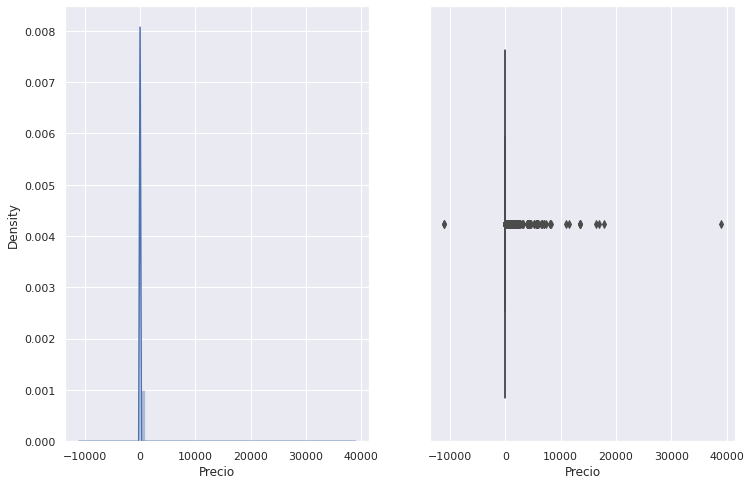

Cantidad


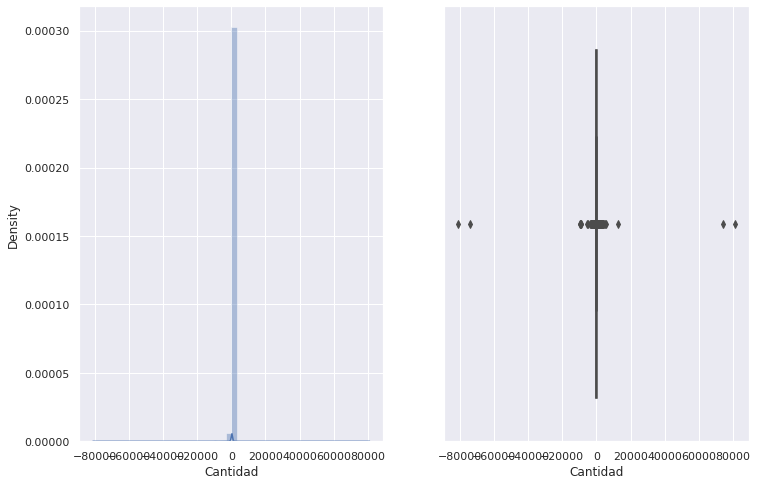

Ingreso


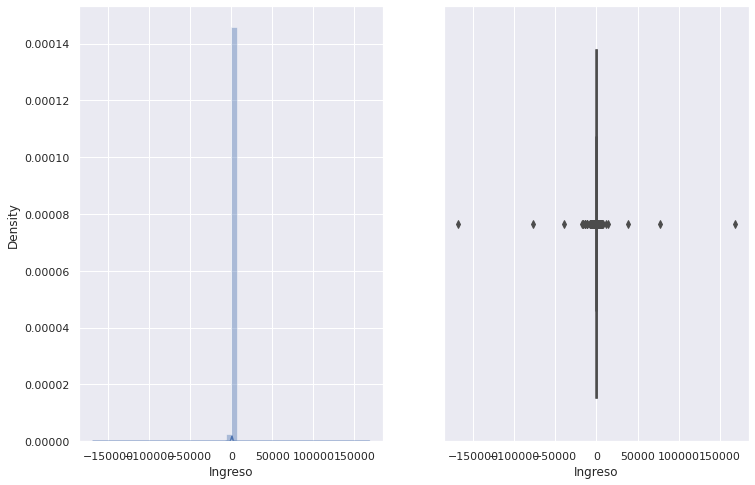

In [ ]:
# Se realiza un gráfico de la distribución y un gráfico de caja-bigotes de cada variable:
sns.set() 
for col in ["Precio", "Cantidad", "Ingreso"]:
  print(col)
  fig, ax= plt.subplots(1,2, figsize=(12,8))
  ax[0]= sns.distplot(data[col], ax=ax[0])
  ax[1]= sns.boxplot(data[col], ax=ax[1])
  plt.show()

Como se mencionó anteriormente las 3 variables cuentan con gran cantidad de datos extremos.

Asimetría: 185.600448
Curtosis: 58433.135911


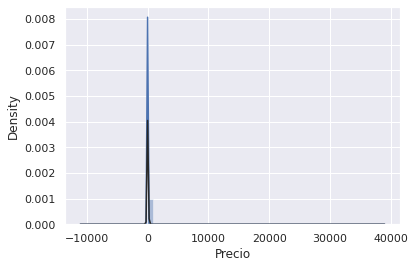

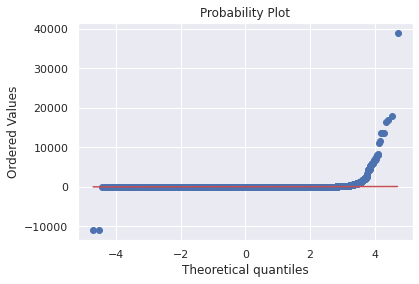

In [ ]:
# Se analiza en detalle la distribución de la variable "Precio":
sns.distplot(data["Precio"], fit = norm);
fig = plt.figure()
res = stats.probplot(data["Precio"], plot = plt)
print("Asimetría: %f" % data["Precio" ].skew())
print("Curtosis: %f" % data["Precio" ].kurt())

La variable "Precio" es asimétrica hacia la derecha y tiene una distribución leptocúrtica (ya que el coeficiente de curtosis es positivo y existe una mayor concentración de los datos en torno a la media).

Asimetría: -0.263921
Curtosis: 118645.544552


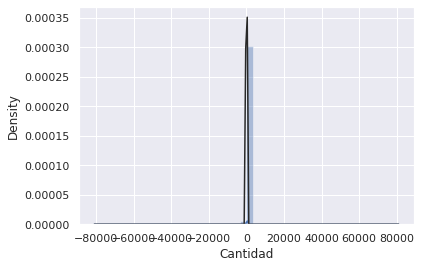

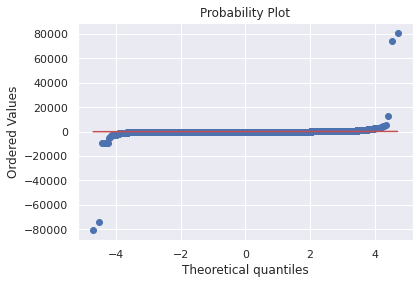

In [ ]:
# Se analiza en detalle la distribución de la variable "Cantidad":
sns.distplot(data["Cantidad"], fit = norm);
fig = plt.figure()
res = stats.probplot(data["Cantidad"], plot = plt)
print("Asimetría: %f" % data["Cantidad" ].skew())
print("Curtosis: %f" % data["Cantidad" ].kurt())

La variable "Cantidad" es asimétrica hacia la izquierda y tiene una distribución leptocúrtica (ya que el coeficiente de curtosis es positivo y existe una mayor concentración de los datos en torno a la media).

Asimetría: -0.960734
Curtosis: 149742.859416


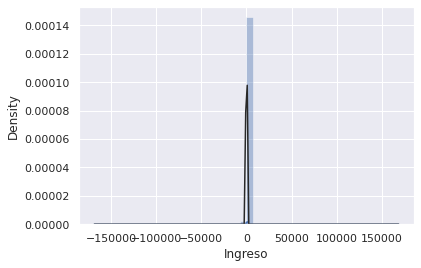

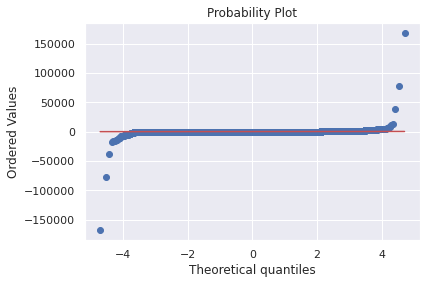

In [ ]:
# Se analiza en detalle la distribución de la variable "Ingreso":
sns.distplot(data["Ingreso"], fit = norm);
fig = plt.figure()
res = stats.probplot(data["Ingreso"], plot = plt)
print("Asimetría: %f" % data["Ingreso" ].skew())
print("Curtosis: %f" % data["Ingreso" ].kurt())

La variable "Ingreso" es asimétrica hacia la izquierda y tiene una distribución leptocúrtica (ya que el coeficiente de curtosis es positivo y existe una mayor concentración de los datos en torno a la media).

**- Variables Cualitativas**

In [ ]:
# Se identifican las variables cualitativas
ColumnasCualitativas = data.dtypes[data.dtypes == "object"].index
ColumnasCualitativas

Index(['N_Factura', 'N_Stock', 'Descripcion', 'ID_Cliente', 'Pais'], dtype='object')

In [ ]:
# Se itera en cada una de las columnas cualitativas para determinar cuales son cuasiconstantes en base al treshold fijado:
Columnas_Cuasi_Const_Cual = [ ]
for col in ColumnasCualitativas:
  if IsQuasiConstant(data[col]):
    Columnas_Cuasi_Const_Cual.append(col)

Columnas_Cuasi_Const_Cual

['Pais']

In [ ]:
# Se observa si hay columnas cualitativas cuasiconstantes:
Columnas_Cuasi_Const_Cual

['Pais']

Respecto a las columnas cualitativas, "Pais" presenta muy poca variabilidad en sus datos. Se analizará mas adelante en detalle esta columna.

In [ ]:
# Se observa a través de un dataframe un resúmen estadístico de las variable cualitativas:
ColumnasCualitativas = data[["Descripcion", "Pais"]]
ColumnasCualitativas.describe().T

,count,unique,top,freq
Descripcion,535187,4223,WHITE HANGING HEART T-LIGHT HOLDER,2357
Pais,536641,38,United Kingdom,490300


Analizando exclusivamente las columnas "Descripcion" y "Pais", se deduce que el producto mas vendido fue "WHITE HANGING HEART T-LIGHT HOLDER" con 2357 ventas y el pais con mas compras realizada fue "United Kingdom" con 490.300 productos comprados.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

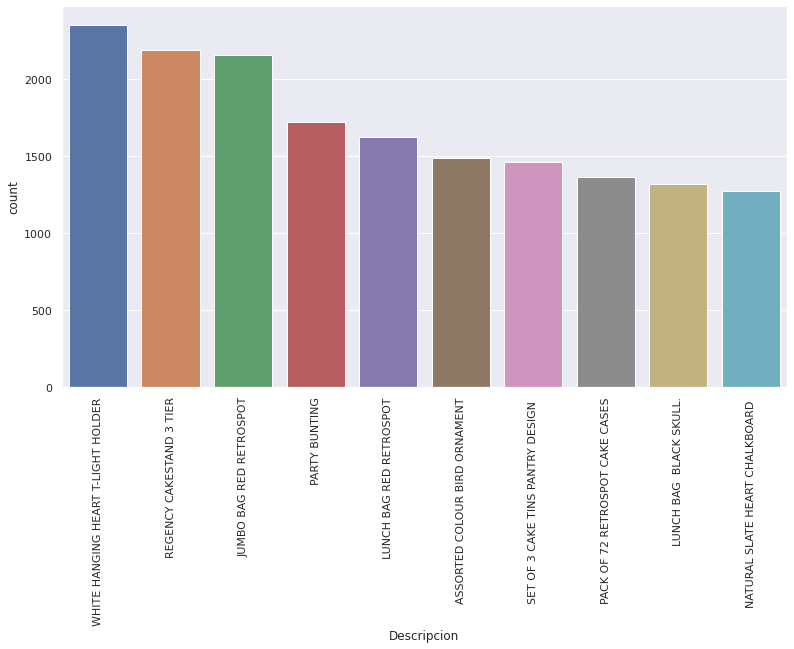

In [ ]:
# Se observa en detalle las  10 clases principales de la variable Descripcion a través de un gráfico de barras:
plt.figure(figsize=(13, 7))
sns.countplot(data["Descripcion"], order = data["Descripcion"].value_counts().iloc[:10].index)
plt.xticks(rotation=90)


Se corrobora mediante el gráfico de barras que "WHITE HANGING HEART T-LIGHT HOLDER" fue el producto mas vendido, seguido de "REGENCY CAKESTAND 3 TIER" Y "JUMBO BAG RED RETROSPOT".

In [ ]:
# Se analiza en detalle la variable "País":
data["Pais"].value_counts(normalize=True)

United Kingdom          0.913646
Germany                 0.017665
France                  0.015916
EIRE                    0.015250
Spain                   0.004711
Netherlands             0.004418
Belgium                 0.003855
Switzerland             0.003716
Portugal                0.002814
Australia               0.002344
Norway                  0.002024
Italy                   0.001496
Channel Islands         0.001411
Finland                 0.001295
Cyprus                  0.001139
Sweden                  0.000859
Unspecified             0.000824
Austria                 0.000747
Denmark                 0.000725
Japan                   0.000667
Poland                  0.000635
Israel                  0.000548
USA                     0.000542
Hong Kong               0.000529
Singapore               0.000427
Iceland                 0.000339
Canada                  0.000281
Greece                  0.000272
Malta                   0.000237
United Arab Emirates    0.000127
European C

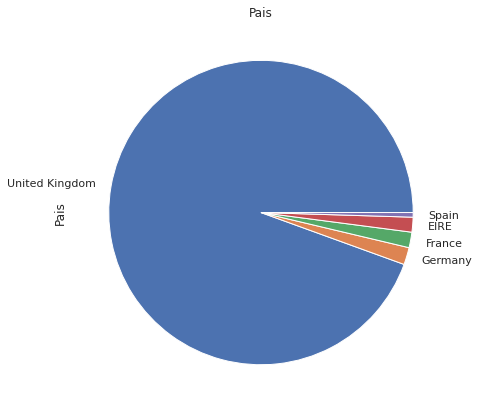

In [ ]:
# Se grafica la distribución de la variable Pais a través de un gráfico de torta tomando las principales cinco clases:
plot = data["Pais"].value_counts().iloc[:5].plot(kind='pie', 
                                            figsize=(13, 7),
                                            title="Pais")


Se corrobora que la variable "Pais" presenta muy poca variabilidad, ya que el 91% de las compras fueron realizadas por "United Kingdom". Es importante recalcar que si se fuera a llevar a cabo un modelo de machine learning no sería conveniente para el modelo utilizar esta variable dentro de las variables predictoras.

**6) Análisis del Ingreso Mensual**

En primer lugar se hará el cálculo de distintas métricas relacionadas al ingreso mensual.


In [ ]:
# Se crea un nuevo dataframe para calcular el ingreso por mes:
ingreso = data.groupby(["Mes"])["Ingreso"].sum().reset_index()
ingreso

,Mes,Ingreso
0,201012,746723.610
1,201101,558448.560
2,201102,497026.410
3,201103,682013.980
4,201104,492367.841
5,201105,722094.100
6,201106,689977.230
7,201107,680156.991
8,201108,681386.460
9,201109,1017596.682


In [ ]:
# Se realiza un gráfico de lineas para observar el ingreso mensual:
plot_data = [
    go.Scatter(
        x=ingreso["Mes"],
        y=ingreso["Ingreso"],)]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title="Ingreso Mensual"
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

El gráfico muestra que el ingreso mensual va en alza, alcanzando su pico en el mes de noviembre de 2011. Es importante destacar que los datos de diciembre no están completos y por este motivo se observa la caída en dicho mes.

In [ ]:
# Se calcula la tasa variación del ingreso mensual:
ingreso["Tasa_variacion"] = ingreso["Ingreso"].pct_change() # El método pct_change permite observar el cambio porcental
ingreso

,Mes,Ingreso,Tasa_variacion
0,201012,746723.610,NaN
1,201101,558448.560,-0.252135
2,201102,497026.410,-0.109987
3,201103,682013.980,0.372189
4,201104,492367.841,-0.278068
5,201105,722094.100,0.466574
6,201106,689977.230,-0.044477
7,201107,680156.991,-0.014233
8,201108,681386.460,0.001808
9,201109,1017596.682,0.493421


In [ ]:
# Se realiza un gráfico de linea para ver la variación de la tasa de variación del ingreso mensual:
plot_data = [
    go.Scatter(
        x=ingreso.query("Mes < 201112")["Mes"],
        y=ingreso.query("Mes < 201112")["Tasa_variacion"],)]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title="Tasa de variación del ingreso mensual")
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

En noviembre 2011 respecto a octubre del mismo año se observa un crecimiento del 36,52% en las ventas (se excluye del gráfico al mes de diciembre 2011 por estar incompleto). A su vez es interesante analizar en detalle que sucede en el mes de abril 2011, el cual tiene la tasa de caida de ingreso mensual mas baja del periodo de análisis. La caída en los ingresos en este mes: ¿se debe a que los clientes hicieron menos pedidos, ó a que en dicho mes se vendieron productos mas baratos?



In [ ]:
# Se calcular el total de ingresos por País:
data.groupby("Pais")["Ingreso"].sum().sort_values(ascending=False).astype(int)


Pais
United Kingdom          8167128
Netherlands              284661
EIRE                     262993
Germany                  221509
France                   197317
Australia                137009
Switzerland               56363
Spain                     54756
Belgium                   40910
Sweden                    36585
Japan                     35340
Norway                    35163
Portugal                  29302
Finland                   22326
Channel Islands           20076
Denmark                   18768
Italy                     16890
Cyprus                    12858
Austria                   10154
Hong Kong                  9908
Singapore                  9120
Israel                     7901
Poland                     7213
Unspecified                4740
Greece                     4710
Iceland                    4310
Canada                     3666
Malta                      2505
United Arab Emirates       1902
USA                        1730
Lebanon                    1693
Lit

* Dado que existe una gran diferencia en los ingresos generados por clientes de "United Kingdom" se tomarán solamente los datos referentes a este país.

In [ ]:
# Primero se crea un nuevo dataframe solo con los clientes de UK:
data_uk = data.query("Pais =='United Kingdom'").reset_index(drop=True)
data_uk.head(2)

,N_Factura,N_Stock,Descripcion,Cantidad,F_Factura,Precio,ID_Cliente,Pais,Mes,Ingreso
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [ ]:
# Se observa en detalle la información principal del nuevo dataframe:
data_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490300 entries, 0 to 490299
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   N_Factura    490300 non-null  object        
 1   N_Stock      490300 non-null  object        
 2   Descripcion  488846 non-null  object        
 3   Cantidad     490300 non-null  int64         
 4   F_Factura    490300 non-null  datetime64[ns]
 5   Precio       490300 non-null  float64       
 6   ID_Cliente   356728 non-null  object        
 7   Pais         490300 non-null  object        
 8   Mes          490300 non-null  int64         
 9   Ingreso      490300 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 37.4+ MB


In [ ]:
# A continuación se calcula la cantidad de clientes activos por mes contando los IDs unicos:
clientes_activos = data_uk.groupby("Mes")["ID_Cliente"].nunique().reset_index()
clientes_activos.head()

,Mes,ID_Cliente
0,201012,871
1,201101,684
2,201102,714
3,201103,923
4,201104,817


In [ ]:
# Se calcula la media de clientes activos por mes:
clientes_activos["ID_Cliente"].mean().round()


948.0

Por mes hubo en promedio 948 clientes activos, es decir, que realizaron compras.

In [ ]:
# Se realiza un gráfico de barras para analizar la variación de la cantidad de clientes activos por mes:
plot_data = [
    go.Bar(
        x=clientes_activos["Mes"],
        y=clientes_activos["ID_Cliente"], )]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title="Cantidad de Clientes Activos por Mes")
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

En el mes de abril de 2011 hubo una disminución de 106 clientes activos respecto al mes de marzo, es decir, un 11.5% menos.

* A continuación se calcula la cantidad de productos vendidos por mes:

In [ ]:
# Se crea un nuevo dataframe con la cantidad de ventas por mes (partiendo del dataframe de los clientes de UK):
productos_vendidos = data_uk.groupby("Mes")["Cantidad"].sum().reset_index()
productos_vendidos



,Mes,Cantidad
0,201012,296934
1,201101,236780
2,201102,225062
3,201103,279138
4,201104,256805
5,201105,305739
6,201106,257852
7,201107,322078
8,201108,319073
9,201109,457449


In [ ]:
# Se calcula el promedio de cantidad de productos vendidos al mes:
productos_vendidos["Cantidad"].mean().round()


326948.0

La cantidad promedio de productos vendidos por mes fue de 326.948 unidades.

In [ ]:
# Se realiza un gráfico de barras de la cantidad de productos vendidos al mes:
plot_data = [
    go.Bar(
        x=productos_vendidos["Mes"],
        y=productos_vendidos["Cantidad"],)]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title="Cantidad de Productos Vendidos al Mes" )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


 Como era de esperar, la cantidad de productos vendidos en el mes de abril 2011 tuvo una caía del 8% respecto al mes de marzo, dejando en evidencia que la disminución en la cantidad de clientes activos afectó negativamente a la cantidad de ventas que se realizaron en dicho mes.

In [ ]:
# Se calcula el Ingreso Promedio mensual por venta realizada: 
# Se crea un nuevo dataframe con el ingreso promedio por venta por mes (partiendo del dataframe de los clientes de UK):
ingreso_promedio_venta = data_uk.groupby("Mes")["Ingreso"].mean().reset_index()
ingreso_promedio_venta

,Mes,Ingreso
0,201012,17.023717
1,201101,13.677282
2,201102,16.198261
3,201103,16.833219
4,201104,15.865103
5,201105,17.807473
6,201106,16.812415
7,201107,15.799956
8,201108,17.394441
9,201109,19.040231


In [ ]:
# Se calcula la media del ingreso promedio por mes: 
ingreso_promedio_venta.Ingreso.mean().round(1)


16.6

El ingreso promedio mensual por venta individual fue de 16.6 usd. 

In [ ]:
# Se realiza un gráfico de barras del ingreso promedio por mes:
plot_data = [
    go.Bar(
        x=ingreso_promedio_venta["Mes"],
        y=ingreso_promedio_venta["Ingreso"],)]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title="Ingreso Promedio por Venta por Mes")
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


Se comprueba que en abril 2011 también cayó el ingreso promedio por venta respecto al mes anterior: de 16,8 usd a 15,9 usd., lo cual también contribuyó a la caída en los ingresos dicho mes.


**7) Cálculo de Métricas**

A continuación se realizará el cálculo de tres métricas importantes:

- **Tasa de clientes nuevos (mensual):** indica la cantidad de nuevos clientes por mes respecto a la totalidad de clientes que realizaron compras dicho mes.

- **Tasa de retención clientes (mensual):** indica la cantidad de clientes que se retienen durante un período de tiempo específico. Se calcularán la tasa de retención mensual y la tasa de retención basada en cohortes.

- **Tasa de abandono de clientes (mensual):** mide el porcentaje de clientes que prescinden de los servicios o productos de una compañía en un período de tiempo concreto.

**- Tasa Clientes Nuevos (mensual)**

Primero se debe definir que es un nuevo cliente. En este conjunto de datos, se puede suponer que un nuevo cliente es quien hizo su primera compra en un mes determinado.

In [ ]:
# Primero se crea un dataframe que contenga los ID de cada cliente (del Reino Unido) y su primer compra (utilizando la función .min()):
primer_compra = data_uk.groupby("ID_Cliente").F_Factura.min().reset_index()
primer_compra.columns = ["ID_Cliente","Fecha_Primer_Compra"]
primer_compra["Mes_Primer_Compra"] = primer_compra["Fecha_Primer_Compra"].map(lambda date: 100*date.year + date.month)
primer_compra.head(2)


,ID_Cliente,Fecha_Primer_Compra,Mes_Primer_Compra
0,12346.0,2011-01-18 10:01:00,201101
1,12747.0,2010-12-05 15:38:00,201012


In [ ]:
# Se unen los dos dataframes a través de la columna "CustomerID":
data_uk = pd.merge(data_uk, primer_compra, on="ID_Cliente")
data_uk.head(2)

,N_Factura,N_Stock,Descripcion,Cantidad,F_Factura,Precio,ID_Cliente,Pais,Mes,Ingreso,Fecha_Primer_Compra,Mes_Primer_Compra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012


In [ ]:
# Se crea la columna Tipo_Usuario para luego definir si cada cliente es nuevo o ya existente:
data_uk["Tipo_Usuario"] = "Nuevo"
data_uk.loc[data_uk["Mes"]>data_uk["Mes_Primer_Compra"],"Tipo_Usuario"] = "Existente"
data_uk.head(2)

,N_Factura,N_Stock,Descripcion,Cantidad,F_Factura,Precio,ID_Cliente,Pais,Mes,Ingreso,Fecha_Primer_Compra,Mes_Primer_Compra,Tipo_Usuario
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012,Nuevo
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,Nuevo


In [ ]:
# Se observa la cantidad de usuarios existentes y usuarios nuevos:
data_uk.Tipo_Usuario.value_counts()


Existente    252836
Nuevo        103892
Name: Tipo_Usuario, dtype: int64

In [ ]:
# Se calcula el ingreso por mes por cada tipo de usuario:
ingreso_tipo_usuario = data_uk.groupby(["Mes","Tipo_Usuario"])["Ingreso"].sum().reset_index()
# Se excluye diciembre de 2010 ya que son todos clientes nuevos y diciembre 2011 dado que los datos del mes no están completos:
ingreso_tipo_usuario.query("Mes != 201012 and Mes != 201112")


,Mes,Tipo_Usuario,Ingreso
1,201101,Existente,194770.040
2,201101,Nuevo,155898.760
3,201102,Existente,220413.530
4,201102,Nuevo,127443.020
5,201103,Existente,295407.920
6,201103,Nuevo,160126.150
7,201104,Existente,267603.920
8,201104,Nuevo,108315.311
9,201105,Existente,433872.470
10,201105,Nuevo,90491.410


In [ ]:
# Se realiza un gráfico de barras del ingreso mensual por tipo de cliente:
# En primer lugar se filtra el dataframe para excluir al mes de diciembre 2010(que son todos clientes nuevos) y al mes de diciembre 2012 (que está incompleto):
ingreso_tipo_usuario = ingreso_tipo_usuario.query("Mes != 201012 and Mes != 201112") #--> VER SI NO ESTA REPETIDO ANTES
plot_data = [
    go.Scatter(
        x=ingreso_tipo_usuario.query("Tipo_Usuario == 'Existente'")["Mes"],
        y=ingreso_tipo_usuario.query("Tipo_Usuario == 'Existente'")["Ingreso"],
        name = "Existente" ),
    go.Scatter(
        x=ingreso_tipo_usuario.query("Tipo_Usuario == 'Nuevo'")["Mes"],
        y=ingreso_tipo_usuario.query("Tipo_Usuario == 'Nuevo'")["Ingreso"],
        name = "Nuevo" )]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title= "Ingresos Mensual por tipo de Cliente"
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Los clientes existentes muestran una tendencia positiva y se observa que la base de clientes está creciendo, sin embargo los clientes nuevos tienen una ligera tendencia negativa respecto al ingreso que generan.

* A continuación se calcula la **Tasa de clientes nuevos (mensual)**:

TCN = cantidad clientes nuevos por mes / cantidad de clientes existentes por mes.

In [ ]:
# Se crea un dataframe con la tasa de clientes nuevos mensual:
tasa_nuevos_clientes = data_uk.query("Tipo_Usuario == 'Nuevo'").groupby(["Mes"])["ID_Cliente"].nunique()/data_uk.query("Tipo_Usuario == 'Existente'").groupby(["Mes"])["ID_Cliente"].nunique() 
tasa_nuevos_clientes = tasa_nuevos_clientes.reset_index()
tasa_nuevos_clientes.columns = ["Mes","TCN"]
tasa_nuevos_clientes = tasa_nuevos_clientes.dropna() # Se elimina la fecha 201012 ya que el ratio de nuevos clientes es cero
tasa_nuevos_clientes 


,Mes,TCN
1,201101,1.124224
2,201102,0.904000
3,201103,0.792233
4,201104,0.510166
5,201105,0.343793
6,201106,0.281250
7,201107,0.236589
8,201108,0.192572
9,201109,0.304878
10,201110,0.328852


In [ ]:
# Se realiza un gráfico de barras de la Tasa Mensual de Clientes Nuevos:
plot_data = [
    go.Bar(
        x=tasa_nuevos_clientes.query("Mes>=201101 and Mes<201112")["Mes"],
        y=tasa_nuevos_clientes.query("Mes>201101 and Mes<201112")["TCN"],)]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title="Tasa Mensual de Clientes Nuevos" )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Se observa que la Tasa de clientes ha ido disminuyendo con el paso de los meses.

**- Tasa de retención de clentes (mensual)**

La tasa de retención de clientes es una métrica que debe monitorearse muy de cerca dado indica qué tan "bueno" es el servicio/producto que vende la empresa y qué tan bien se adapta ésta al mercado. Para calcular esta tasa es necesario definir cuántos clientes se retuvieron del mes anterior.


TR = clientes retenidos del mes anterior / total clientes activos

In [ ]:
# Primero se identifica que usuarios están activos por mes en base al ingreso que generan:
clientes_activos_ingreso = data_uk.groupby(["ID_Cliente","Mes"])["Ingreso"].sum().astype(int).reset_index()
clientes_activos_ingreso


,ID_Cliente,Mes,Ingreso
0,12346.0,201101,0
1,12747.0,201012,706
2,12747.0,201101,303
3,12747.0,201103,310
4,12747.0,201105,771
...,...,...,...
12325,18283.0,201110,112
12326,18283.0,201111,637
12327,18283.0,201112,208
12328,18287.0,201105,765


In [ ]:
# Se utiliza el método .crosstab() para crear una matriz de retención:
matriz_retencion = pd.crosstab(clientes_activos_ingreso["ID_Cliente"], clientes_activos_ingreso["Mes"]).reset_index()
matriz_retencion.head()

Mes,ID_Cliente,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1



La tabla de retención nos muestra qué clientes están activos cada mes (1 significa activo).

In [ ]:
# Se calcula el número de clientes retenidos del mes anterior y el número total de clientes.
meses = matriz_retencion.columns[2:]
retencion_array = []
for i in range(len(meses)-1):
    retencion_data = {}
    mes_seleccionado = meses[i+1]
    mes_previo = meses[i]
    retencion_data["Mes"] = int(mes_seleccionado)
    retencion_data["Total_Usuarios"] = matriz_retencion[mes_seleccionado].sum()
    retencion_data["Total_Usuarios_Retenidos"] = matriz_retencion[(matriz_retencion[mes_seleccionado]>0) & (matriz_retencion[mes_previo]>0)][mes_seleccionado].sum()
    retencion_array.append(retencion_data)
    


In [ ]:
# Se crea el dataframe:
matriz_retencion = pd.DataFrame(retencion_array)
matriz_retencion

,Mes,Total_Usuarios,Total_Usuarios_Retenidos
0,201102,714,263
1,201103,923,305
2,201104,817,310
3,201105,985,369
4,201106,943,417
5,201107,899,379
6,201108,867,391
7,201109,1177,417
8,201110,1285,502
9,201111,1548,616


In [ ]:
# Finalmente se calcila la Tasa de Retención:
matriz_retencion["Tasa_Retencion"] = matriz_retencion["Total_Usuarios_Retenidos"]/matriz_retencion["Total_Usuarios"]
matriz_retencion

,Mes,Total_Usuarios,Total_Usuarios_Retenidos,Tasa_Retencion
0,201102,714,263,0.368347
1,201103,923,305,0.330444
2,201104,817,310,0.379437
3,201105,985,369,0.374619
4,201106,943,417,0.442206
5,201107,899,379,0.421580
6,201108,867,391,0.450980
7,201109,1177,417,0.354291
8,201110,1285,502,0.390661
9,201111,1548,616,0.397933


In [ ]:
# Se realiza un gráfico de linea de la Tasa de retención mensual:
plot_data = [
    go.Scatter(
        x=matriz_retencion.query("Mes < 201112")["Mes"],
        y=matriz_retencion.query("Mes < 201112")["Tasa_Retencion"],
        name="organic"  )]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        title="Tasa de retención mensual")
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

La tasa de retención mensual tuvo dos picos significativos en junio y agosto, y dos caídas abruptas, una en marzo y otra en septiembre.

**- Tasa de abandono de clientes (mensual)** 

La fórmula de esta tasa es:

TA = 1 - Tasa de Retención

In [ ]:
# Se calcula la Tasa de abandono mensual:
matriz_retencion["Tasa de Abandono"] =  1- matriz_retencion["Tasa_Retencion"]
matriz_retencion

,Mes,Total_Usuarios,Total_Usuarios_Retenidos,Tasa_Retencion,Tasa de Abandono
0,201102,714,263,0.368347,0.631653
1,201103,923,305,0.330444,0.669556
2,201104,817,310,0.379437,0.620563
3,201105,985,369,0.374619,0.625381
4,201106,943,417,0.442206,0.557794
5,201107,899,379,0.421580,0.578420
6,201108,867,391,0.450980,0.549020
7,201109,1177,417,0.354291,0.645709
8,201110,1285,502,0.390661,0.609339
9,201111,1548,616,0.397933,0.602067


In [ ]:
# Se realiza el gráfico:
plot_data = [
    go.Scatter(
        x=matriz_retencion.query("Mes < 201112")["Mes"],
        y=matriz_retencion.query("Mes < 201112")["Tasa de Abandono"],
        name="organic" )]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title="Tasa Mensual de Abandono"
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

La tasa de abandono es la contrapartida de la tasa de retención. Se observa que en los meses de junio y julio hay una cáida en la tasa de abandono mientras que los valores mas altos se dan en marzo y septiembre.